Written by: Divy Raval

Date: April 9, 2020

# Overview: Correcting Radial-Image Distortions

The purpose of this notebook is to simulate a radial-image distoration correction process and understand the theory behind it. This is acheived through:
1. [Artificial Image Distortion](#Artificial-Image-Distortion)
2. [Image Correction: Undistorting Images](#Image-Correction:-Undistorting-Images)
3. Real-World Application

## General Code-Setup 

In [11]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 110
import math
import scipy.optimize as opt

In [12]:
# exporting images function
def export_image(img, name, k1, k2, k3, tol=None, path="exports/"):
    z = lambda k: "z" + str(k)
    loc = path + name + z(k1) + z(k2) + z(k3) + z(tol) + ".png"
    cv2.imwrite(loc ,dImage);
    

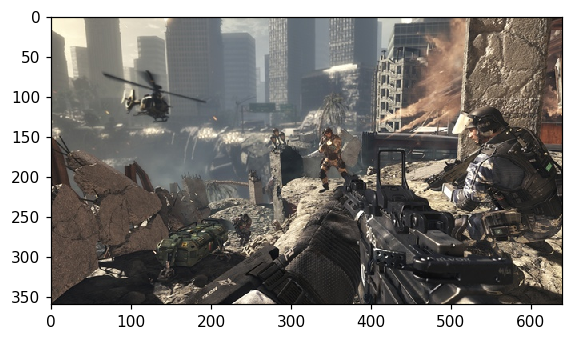

In [13]:
# import image path
imagePath = "data/img03.jpg"  # video-game image
# import image and convert from BGR to RGB colour scale
ogImage = cv2.cvtColor(cv2.imread(imagePath), cv2.COLOR_BGR2RGB)
# original image
plt.imshow(ogImage);

# Artificial Image Distortion

Images can be artificially radially-distored using Brown's distortion model.

$$
\begin{bmatrix} 
    x_{d} \\
    y_{d}
\end{bmatrix}
= (1 + k_1r^2 + k_2r^4 + k_3r^6)
\begin{bmatrix} 
    x_n \\
    y_n
\end{bmatrix}
\hspace{2cm} (1)
$$

$$r=\sqrt{(x_n)^2 + (y_n)^2}\hspace{2cm} (2)$$

where 
$$x_n = x - x_c\hspace{2cm} (3)$$
$$y_n = y - y_c\hspace{2cm} (4)$$.

Here the subscripts $c$, $d$, and $n$ refer to  *centeral*, *distorted*, and *normalized* respectively. Whereas $k_i$ is simply a real-constant involved in the model and can be tweaked as desired.
- Notice that the equation 2 is simple the Eucludian distance in 2-dimensional space, in this case applied to pixels.

In [53]:
# k1, k2, k3 values
kVec = (10**-6, -10**-14, -10**-16)
# center of original image (x, y)
ogCenter = (ogImage.shape[1]//2, ogImage.shape[0]//2)
# oversize distorted heights and widths to ensure no mapping collisions
dImage = np.zeros(shape=(ogImage.shape[0]*5, ogImage.shape[1]*5, 3), dtype=np.uint8)

In [54]:
# distortion algorithm
def distort(pX, pY, center, k1, k2, k3):
    # normalize the pixel
    normX, normY = pX - center[0], pY - center[1]
    # determine r^2
    r2 = normX**2 + normY**2
    # r2 = r^2 thus the exponents are different
    const = 1 + k1*r2 + k2*r2**2 + k3*r2**3
    # return rounded values since floats are nonsensical for pixels
    return int(round(const*normX)), int(round(const*normY))

# apply the distortion
# for pixels in the width
for pX in range(ogImage.shape[1]):
    # for pixels in the height
    for pY in range(ogImage.shape[0]):
        # obtain distorted values
        distX, distY = distort(pX, pY, ogCenter, *kVec) 
        # assign distored values to the dist{X,Y} pixes with a constant shift to ensure +ve
        dImage[distY + dImage.shape[0]//2][distX + dImage.shape[1]//2] = ogImage[pY][pX]

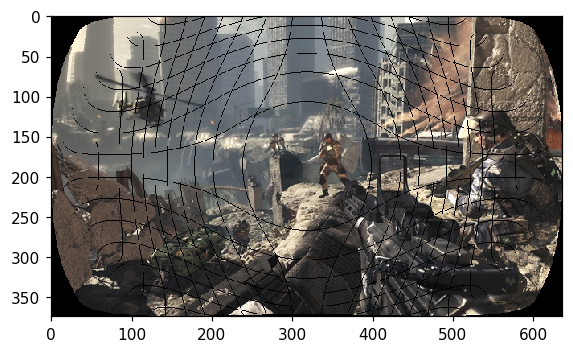

In [55]:
# crop out black rows and columns from the image
def crop_image_only_outside(img, tol=0):
    # source: https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy
    # img is 2D or 3D image data
    # tol  is tolerance
    mask = img>tol
    if img.ndim==3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    return img[row_start:row_end,col_start:col_end]

# crop distorted image to remove excess black regions 
dImage = crop_image_only_outside(dImage)
# save the image
export_image(dImage, "dist1", *kVec)
plt.imshow(dImage);

In [56]:
# bilinear interperlation to fix 'holes' in the image
def bilinear_inter(image, tol=0):
    height, width, _ = image.shape
    def neighbour_average(pX, pY):
        return ((image[pY - 1][pX]) // 4
                + (image[pY + 1][pX]) // 4
                + (image[pY][pX - 1]) // 4
                + (image[pY][pX + 1]) // 4
               )

    if tol > 0:
        for pX in range(width):
            for pY in range(height):
                if not np.allclose(image[pY][pX], [0, 0, 0], atol=tol):
                    continue
                try:
                    image[pY][pX] = neighbour_average(pX, pY)
                except:
                    continue
    else:
        for pX in range(width):
            for pY in range(height):
                if not (image[pY][pX] == [0, 0, 0]).all():
                    continue
                try:
                    image[pY][pX] = neighbour_average(pX, pY)
                except:
                    continue
    return image

# run bilinear interpolation
tol = 0
dImage = bilinear_inter(dImage, tol)

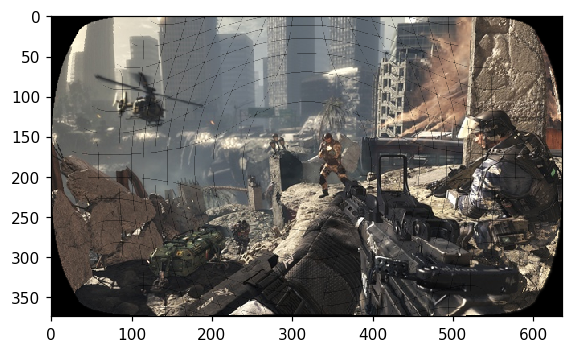

In [57]:
export_image(dImage, "dist2", *kVec, tol=tol)
plt.imshow(dImage);

## Discussing the Code

The $k_i$ values were purposfully choosen to be low as to better simulate practical distortions and additiionally, picking large values results in image sizes that can not be handled by personal computers, pixel dimensions hit the millions when mulitplied by large $r^6$ values. In general, the values of $k_i$ directly impact the *overSizeFactor* which provides enough leeway to prevent distortion effects from exceeding the choosen bounds of the new image.

# Image Correction: Undistorting Images

In [58]:
# distorted image center
dCenter = (dImage.shape[1]//2, dImage.shape[0]//2)
# blank image to undistort on, once again oversize
uImage = np.zeros(shape=(ogImage.shape[0]*3, ogImage.shape[1]*3, 3), dtype=np.uint8)

In [59]:
# undistort assuming k-values and original image size are known.
def undistort(pX, pY, shift, ogCenter, k1, k2, k3):
    # equation to numerically solve for x and y values provided pX and pY
    def equation(p):
        x, y = p
        dX, dY = distort(x, y, ogCenter, k1, k2, k3)
        return dX - (pX - shift[0]), dY - (pY - shift[1])
        
    # use fsolve to solve nonlinear systems of equations
    fX, fY = opt.fsolve(equation, (1, -1))
    return int(round(fX)), int(round(fY))

# undistort
for pX in range(dImage.shape[1]):
    for pY in range(dImage.shape[0]):
        # obtain undistorted values
        uX, uY = undistort(pX, pY, dCenter, ogCenter, *kVec)
        # assign distored values to the dist{X,Y} pixes with a constant shift to ensure +ve
        try:
            uImage[uY + uImage.shape[0]//2][uX + uImage.shape[1]//2] = dImage[pY][pX]
        except:
            continue

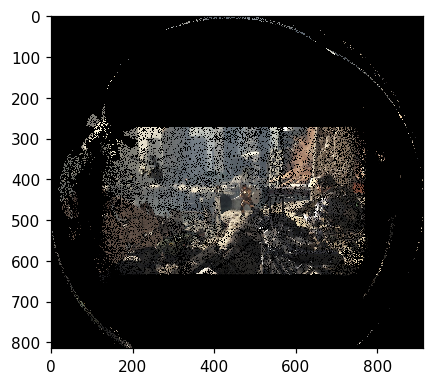

In [60]:
# crop distorted image to remove excess black regions 
uImage = crop_image_only_outside(uImage)
export_image(uImage, "undi1", *kVec)
plt.imshow(uImage);

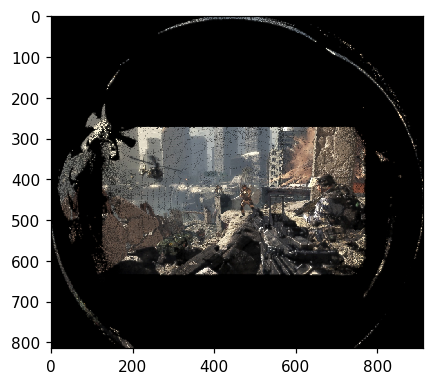

In [63]:
# run bilinear interpolation
tol = 50
uImage = bilinear_inter(uImage, tol)
export_image(uImage, "undi2", *kVec, tol=tol)
plt.imshow(uImage);

## Alternative Approach to Undistorting Images

Source: https://www.researchgate.net/publication/328092228_Calculating_the_Inverse_Radial_Distortion_Model_Based_on_Zhang_method

Secondary Source: https://www.researchgate.net/publication/303703794_An_Exact_Formula_for_Calculating_Inverse_Radial_Lens_Distortions

This alternative method works as an approximation to the inverse radial distortion model. The need for this approximation arises because it is clear that solving the inverse, non-linear, transform of equation (1) is not possible 100% of the time unless you impose countless countraints on the solutions according to MATLAB solver. Try this yourself if there is doubt!.

Equation (1) takes the following form when $r$ is expanded to $(x_n^2+y_n^2)^{1/2}$:

$$x_d = x_n(1 + k_1(x_n^2 + y_n^2) + k_2(x_n^2 + y_n^2)^2 + k_3(x_n^2 + y_n^2)^3)\hspace{2cm} (5)$$
$$y_d = y_n(1 + k_1(x_n^2 + y_n^2) + k_2(x_n^2 + y_n^2)^2 + k_3(x_n^2 + y_n^2)^3)\hspace{2cm} (6)$$

In [64]:
# generate alternative constants k1->b1, k2->b2, k3->b3
bVec = (-kVec[0], 3*kVec[0]**2 - kVec[1], 8*kVec[0]*kVec[1]-12*kVec[0]**3-kVec[2])
# blank image to undistort on, once again oversize
uImage2 = np.zeros(shape=(dImage.shape[0]*2, dImage.shape[1]*2, 3), dtype=np.uint8)

In [65]:
# undistort using the forward distortion function as outlines in the sources
# for pixels in the width
for pX in range(dImage.shape[1]):
    # for pixels in the height
    for pY in range(dImage.shape[0]):
        # obtain distorted values
        distX, distY = distort(pX, pY, dCenter, *bVec)
        # assign distored values to the dist{X,Y} pixes with a constant shift to ensure +ve
        uImage2[distY + uImage.shape[0]//2][distX + uImage.shape[1]//2] = dImage[pY][pX]

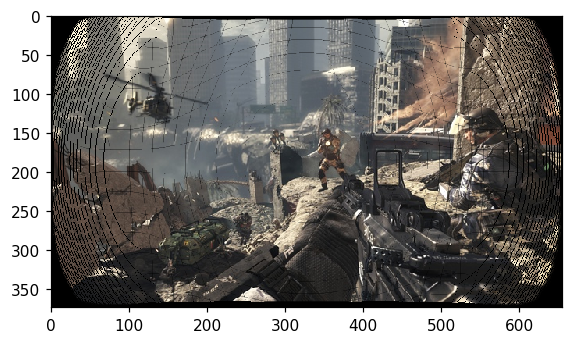

In [66]:
# crop distorted image to remove excess black regions 
uImage2 = crop_image_only_outside(uImage2)
export_image(uImage2, "undi3", *bVec)
plt.imshow(uImage2);

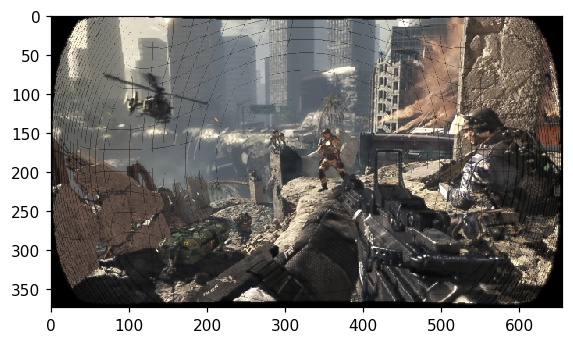

In [67]:
tol = 50
uImage2 = bilinear_inter(uImage2, tol)
export_image(uImage2, "undi4", *bVec, tol=tol)
plt.imshow(uImage2);